In [1]:
import pandas as pd
import numpy as np
import re
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier  # I'm passing on a boosted model in this exercise because it's so computationally expensive
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
%matplotlib inline
plt.style.use('fivethirtyeight')
mpl.rcParams['lines.linewidth'] = 2

## Load data, EDA

In [2]:
# Extract column names from metadata file using regular expressions
columns = []
pattern = r"(^[a-z0-9 \-']+):"
with open('census_income_metadata.txt', 'r') as metadata:
    for line in metadata:
        if re.match(pattern, line):
            columns.append(re.match(pattern, line)[1].replace(' ', '_'))
columns.append('goal')

In [3]:
# Load data
train_data = pd.read_csv('census_income_learn.csv', names=columns, index_col=False)
test_data = pd.read_csv('census_income_test.csv', names=columns, index_col=False)
print(len(train_data))  # should be 199523
print(len(test_data))  # should be 99762

199523
99762


In [4]:
# Drop 'instance_weight' column as per metadata file ("| instance weight: ignore.")
train_data.drop('instance_weight', axis=1, inplace=True)
test_data.drop('instance_weight', axis=1, inplace=True)

In [5]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(train_data.head())

age                  class_of_worker  detailed_industry_recode  \
0   73                  Not in universe                         0   
1   58   Self-employed-not incorporated                         4   
2   18                  Not in universe                         0   
3    9                  Not in universe                         0   
4   10                  Not in universe                         0   

   detailed_occupation_recode                    education  wage_per_hour  \
0                           0         High school graduate              0   
1                          34   Some college but no degree              0   
2                           0                   10th grade              0   
3                           0                     Children              0   
4                           0                     Children              0   

  enroll_in_edu_inst_last_wk    marital_stat           major_industry_code  \
0            Not in universe         Widowed   Not in universe or children   
1            Not in universe        Divorced                  Construction   
2                High school   Never married   Not in universe or children   
3            Not in universe   Never married   Not in universe or children   
4            Not in universe   Never married   Not in universe or children   

                  major_occupation_code                        race  \
0                       Not in universe                       White   
1   Precision production craft & repair                       White   
2                       Not in universe   Asian or Pacific Islander   
3                       Not in universe                       White   
4                       Not in universe                       White   

  hispanic_origin      sex member_of_a_labor_union reason_for_unemployment  \
0       All other   Female         Not in universe         Not in universe   
1       All other     Male         Not in universe         Not in universe   
2       All other   Female         Not in universe         Not in universe   
3       All other   Female         Not in universe         Not in universe   
4       All other   Female         Not in universe         Not in universe   

  full_or_part_time_employment_stat  capital_gains  capital_losses  \
0                Not in labor force              0               0   
1          Children or Armed Forces              0               0   
2                Not in labor force              0               0   
3          Children or Armed Forces              0               0   
4          Children or Armed Forces              0               0   

   dividends_from_stocks      tax_filer_stat region_of_previous_residence  \
0                      0            Nonfiler              Not in universe   
1                      0   Head of household                        South   
2                      0            Nonfiler              Not in universe   
3                      0            Nonfiler              Not in universe   
4                      0            Nonfiler              Not in universe   

  state_of_previous_residence         detailed_household_and_family_stat  \
0             Not in universe   Other Rel 18+ ever marr not in subfamily   
1                    Arkansas                                Householder   
2             Not in universe    Child 18+ never marr Not in a subfamily   
3             Not in universe      Child <18 never marr not in subfamily   
4             Not in universe      Child <18 never marr not in subfamily   

  detailed_household_summary_in_household migration_code-change_in_msa  \
0           Other relative of householder                            ?   
1                             Householder                   MSA to MSA   
2                       Child 18 or older                            ?   
3            Child under 18 never married                     Nonmover   
4            Child under 18 never married        

There are a significant number of columns, especially when one-hot encoding the categorical ones.
I shall build a model using PCA dimensionality reduction to see if it helps

In [6]:
# Check for missing values
train_data[train_data.isnull().any(axis=1)]

Empty DataFrame
Columns: [age, class_of_worker, detailed_industry_recode, detailed_occupation_recode, education, wage_per_hour, enroll_in_edu_inst_last_wk, marital_stat, major_industry_code, major_occupation_code, race, hispanic_origin, sex, member_of_a_labor_union, reason_for_unemployment, full_or_part_time_employment_stat, capital_gains, capital_losses, dividends_from_stocks, tax_filer_stat, region_of_previous_residence, state_of_previous_residence, detailed_household_and_family_stat, detailed_household_summary_in_household, migration_code-change_in_msa, migration_code-change_in_reg, migration_code-move_within_reg, live_in_this_house_1_year_ago, migration_prev_res_in_sunbelt, num_persons_worked_for_employer, family_members_under_18, country_of_birth_father, country_of_birth_mother, country_of_birth_self, citizenship, own_business_or_self_employed, fill_inc_questionnaire_for_veteran's_admin, veterans_benefits, weeks_worked_in_year, year, goal]
Index: []

[0 rows x 41 columns]

Great! There are no missing values

In [7]:
# Let's count duplicate rows to ensure it matches what's stated in the metadata file
print(len(train_data[train_data.duplicated()]))  # should be 46716
print(len(test_data[test_data.duplicated()]))  # should be 20936

46627
20898


There are about 0.2% fewer duplicates than expected. That's curious, but not enough to concern me.
It could be due to a mistake in the metadata file, a difference in how I'm handling the 'instance_weight' column, or how "conflicting" instances are defined.

In [8]:
# Let's drop duplicates
train_data.drop_duplicates(inplace=True)
test_data.drop_duplicates(inplace=True)

In [9]:
# Check class balance
print('{:.1f}% of the records earn less than $50,000'.format(100 * len(train_data[train_data['goal'] == ' - 50000.']) / len(train_data)))
print('{:.1f}% of the records earn more than $50,000'.format(100 * len(train_data[train_data['goal'] == ' 50000+.']) / len(train_data)))

91.9% of the records earn less than $50,000
8.1% of the records earn more than $50,000


Class imbalance is quite high, therefore accuracy may not work well for an evaluation metric.
I will use f1_score as the scoring mectric because it is unclear if False Negatives or False Positives are more costly.
I will also attempt to use SMOTE to rebalance the dataset.

In [10]:
# Which rows contain 'Not in universe'?
print(len(train_data[train_data.isin([' Not in universe']).any(axis=1)]))
print(len(train_data))

152896
152896


All rows contain 'Not in universe' in at least one column. Therefore, I cannot drop those rows.

In [11]:
# Which columns contain 'Not in universe'? Can we drop those columns?
train_data.columns[train_data.isin([' Not in universe']).any()]

Index(['class_of_worker', 'enroll_in_edu_inst_last_wk',
       'major_occupation_code', 'member_of_a_labor_union',
       'reason_for_unemployment', 'region_of_previous_residence',
       'state_of_previous_residence', 'migration_code-change_in_msa',
       'migration_code-change_in_reg', 'migration_code-move_within_reg',
       'migration_prev_res_in_sunbelt', 'family_members_under_18',
       'fill_inc_questionnaire_for_veteran's_admin'],
      dtype='object')

It seems that with these columns, values of 'Not in universe' have meaning.
For example, 'Not in universe' for class_of_worker column seems to simply mean 'Unemployed'.
I'll leave these columns in, untreated. The tree models should ignore them if they don't help the model.

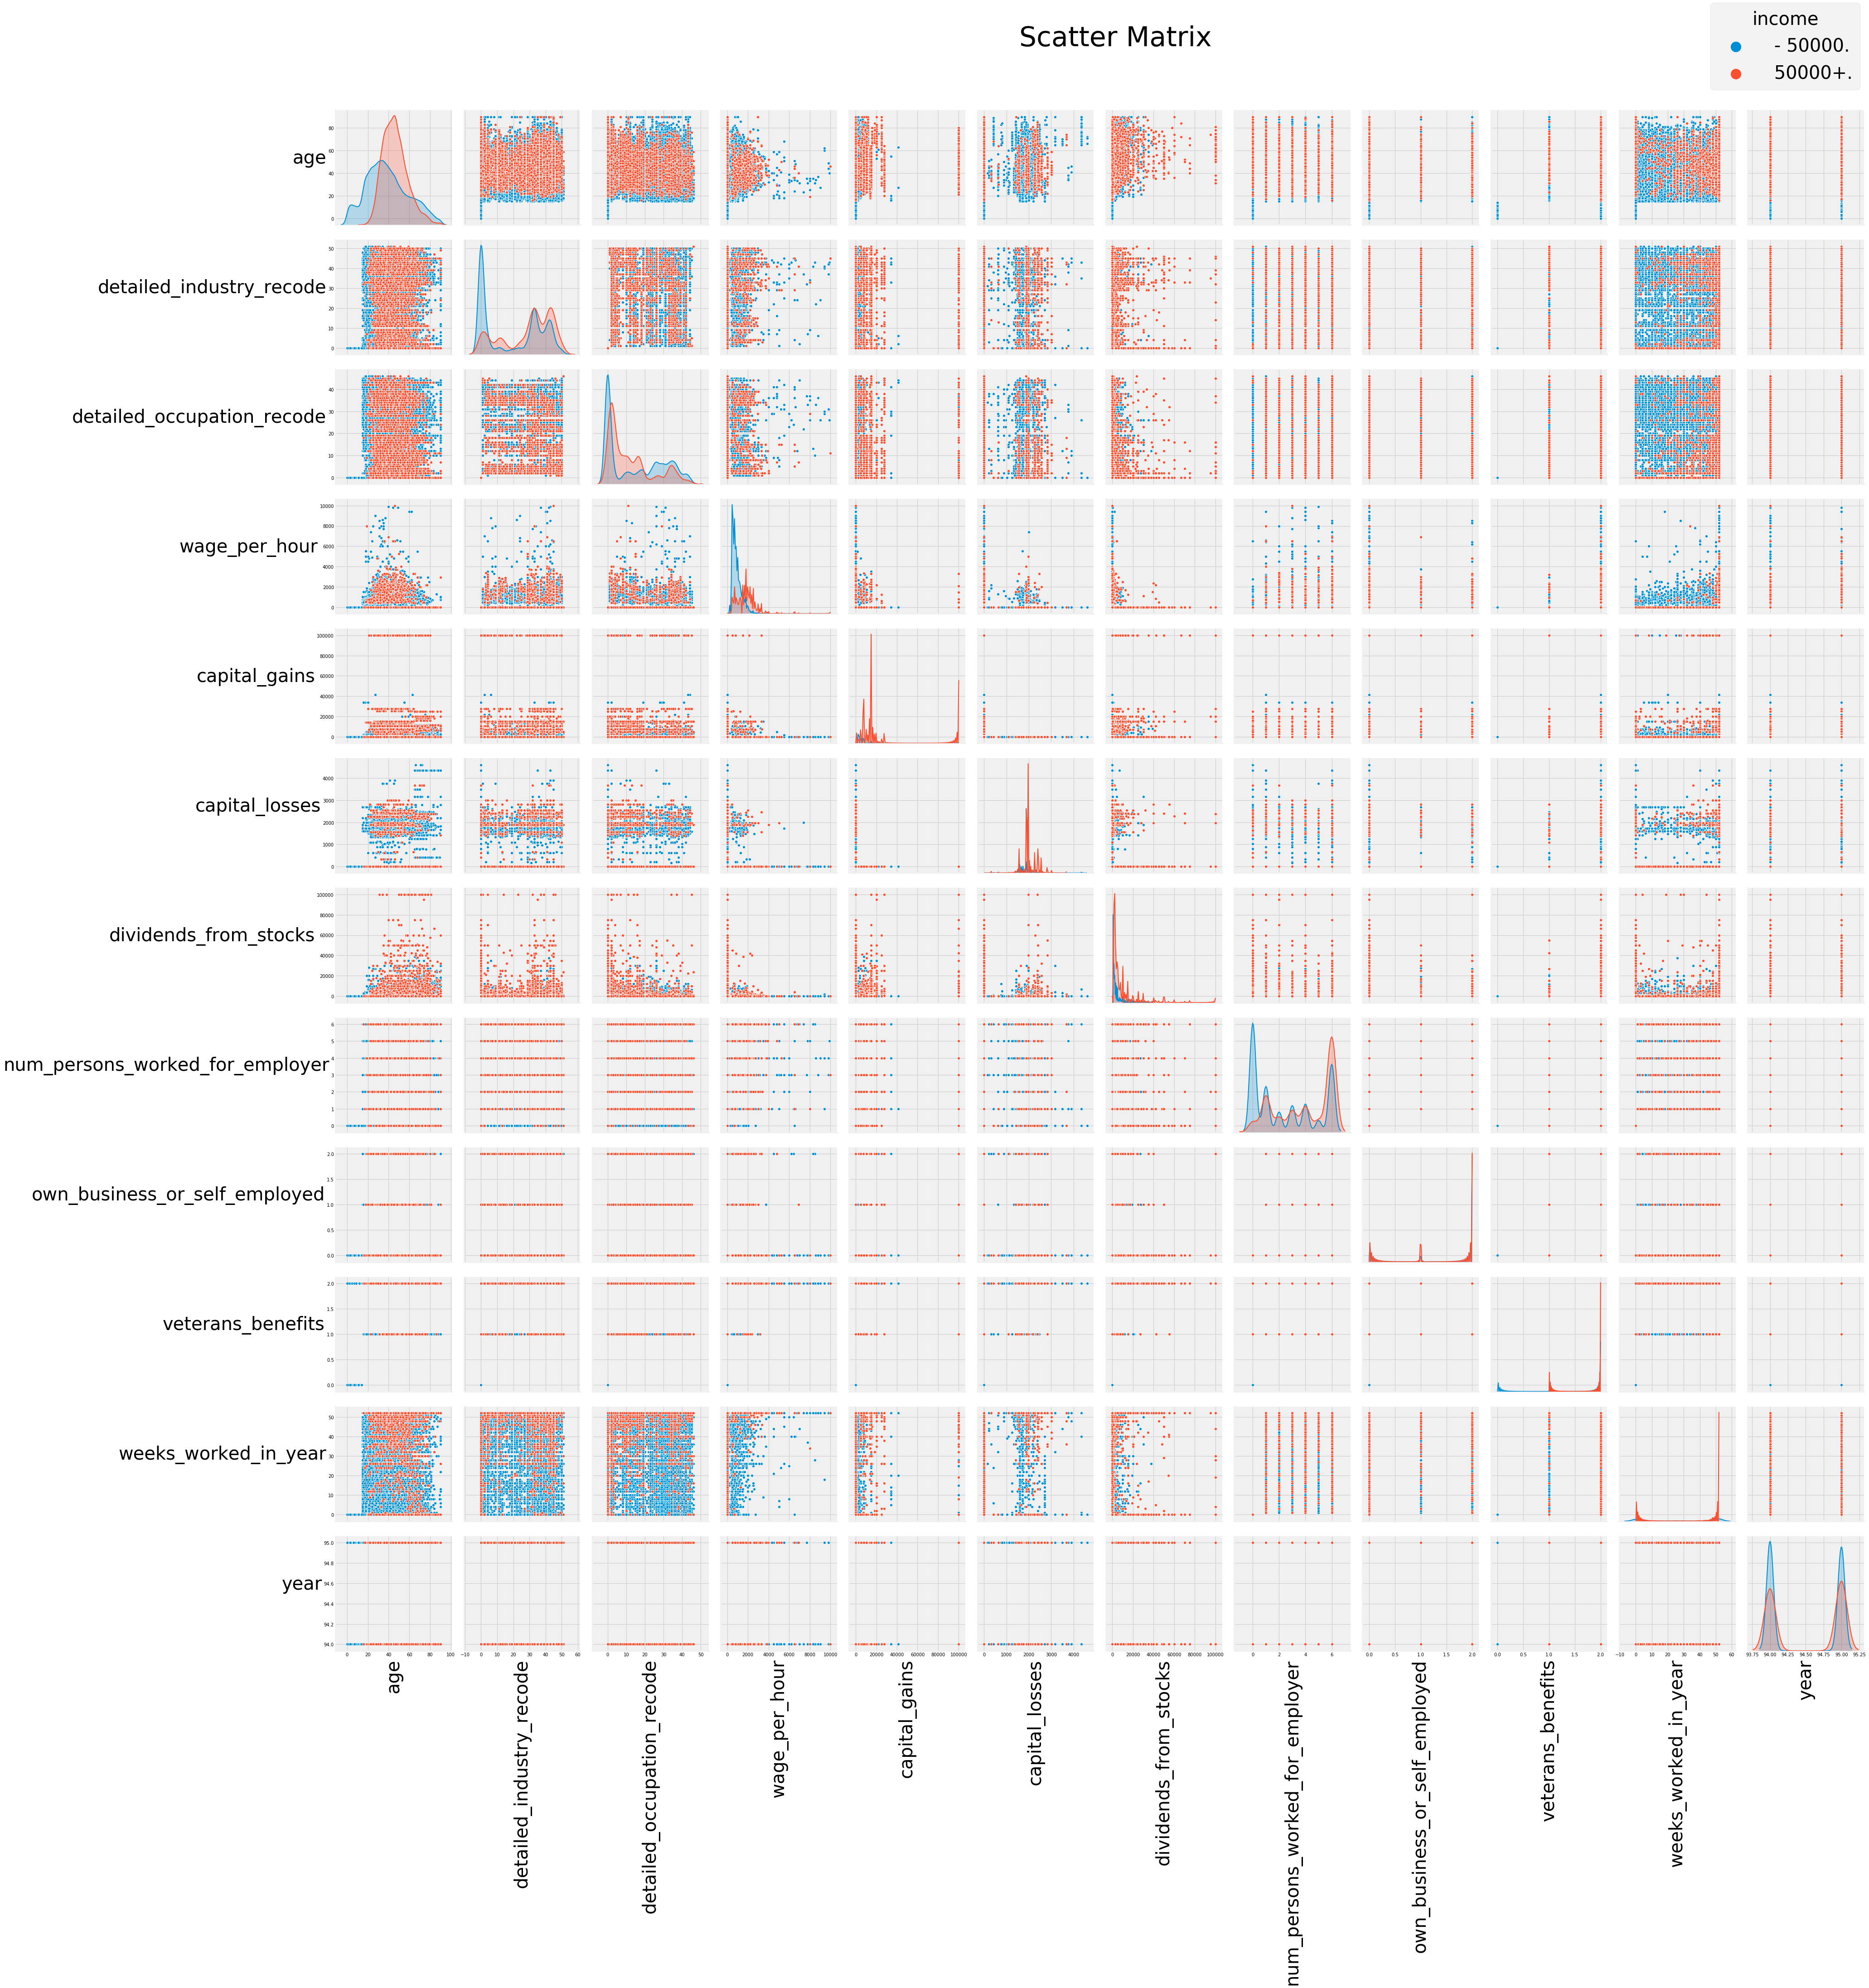

In [12]:
# Examine scatter matrix in order to see if any two-variable combinations are heavily correlated
g = sns.pairplot(train_data, hue='goal', height=4)
g.fig.draw(g.fig.canvas.get_renderer())
for ax in g.axes.flat:
    ax.set_xlabel(ax.get_xlabel(), fontsize=40, rotation=90)
    ax.set_ylabel(ax.get_ylabel(), fontsize=40, rotation=0, horizontalalignment='right')
g._legend.remove()
plt.legend(title='income',
           fontsize='40',
           markerscale=4,
           title_fontsize='40',
           bbox_to_anchor=(.97, 1.07),
           bbox_transform=plt.gcf().transFigure)
g.fig.suptitle('Scatter Matrix', fontsize='60', y=1.05)
plt.show()

I don't see any clear linear relationships so I don't expect logistic regression to perform well.
I'll try a nearest neighbors model and a tree model to capture non-linear relationships.
However, with the high-diensionality of this data, I expect knn to perform poorly without dimensionality reduction

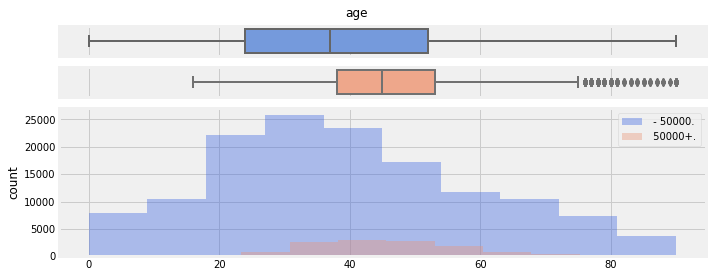

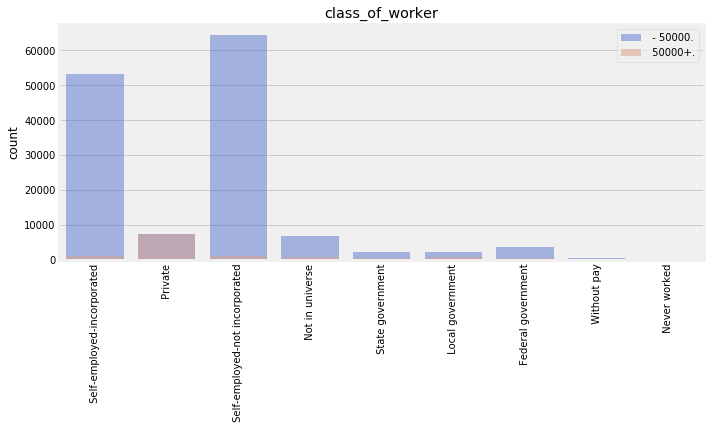

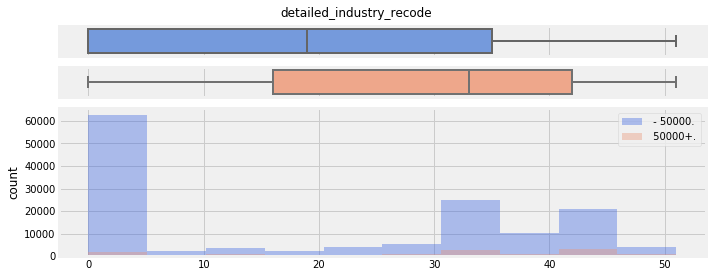

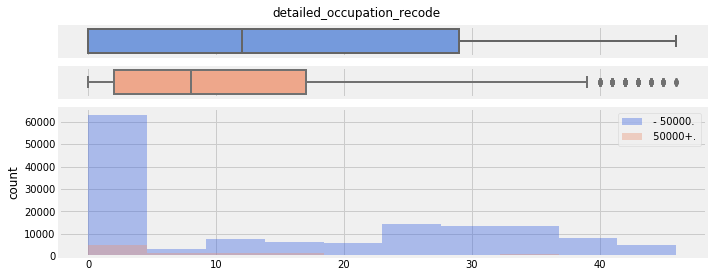

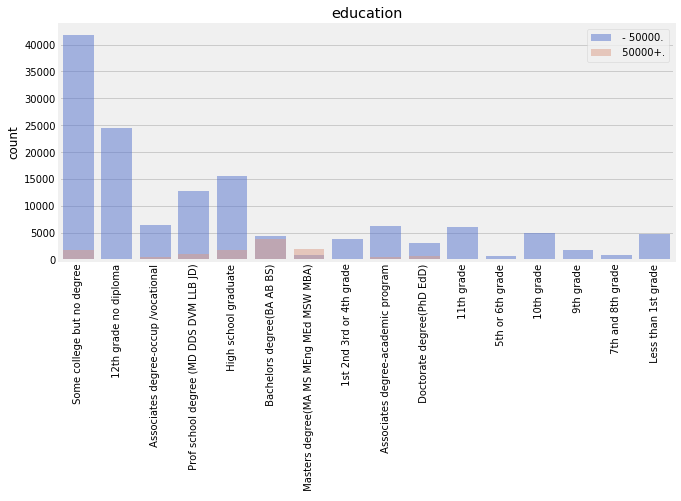

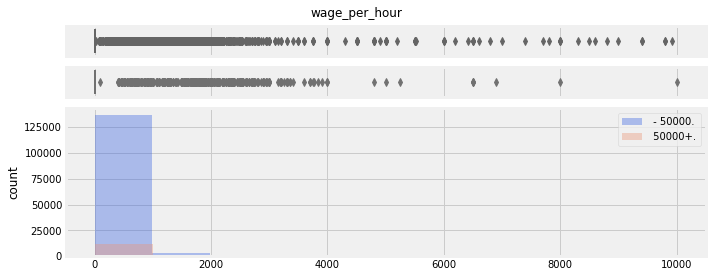

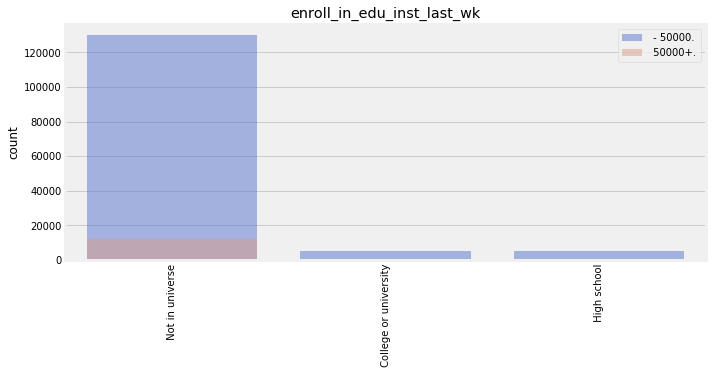

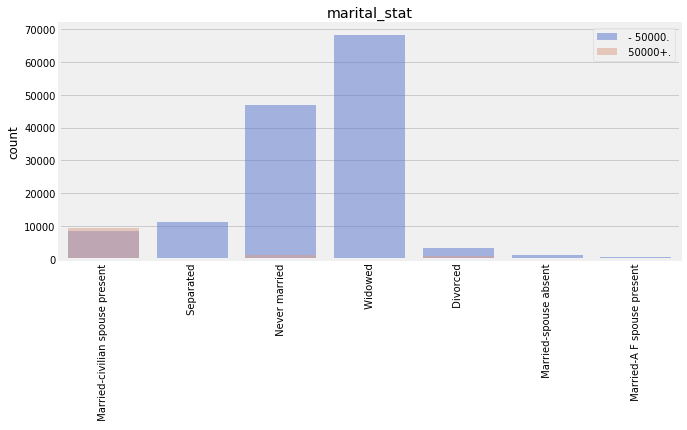

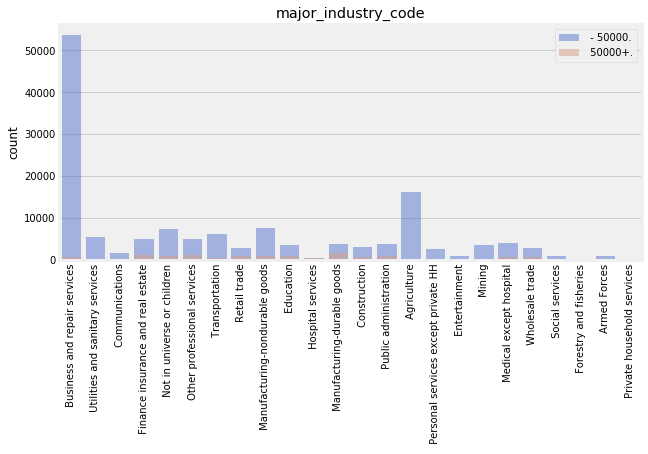

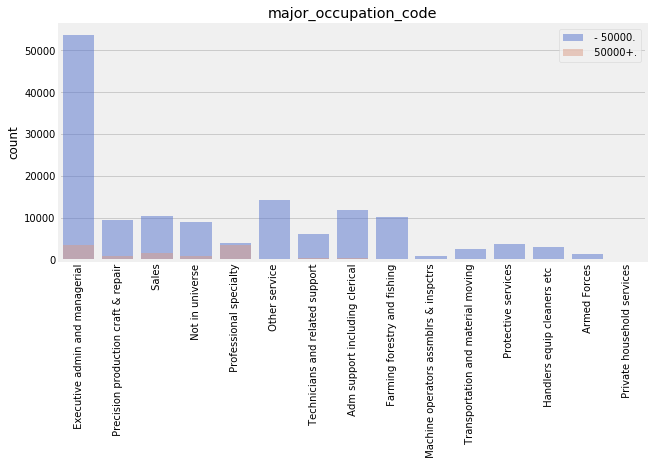

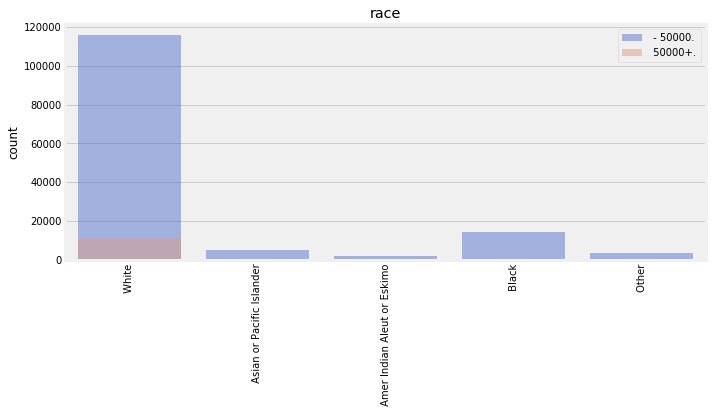

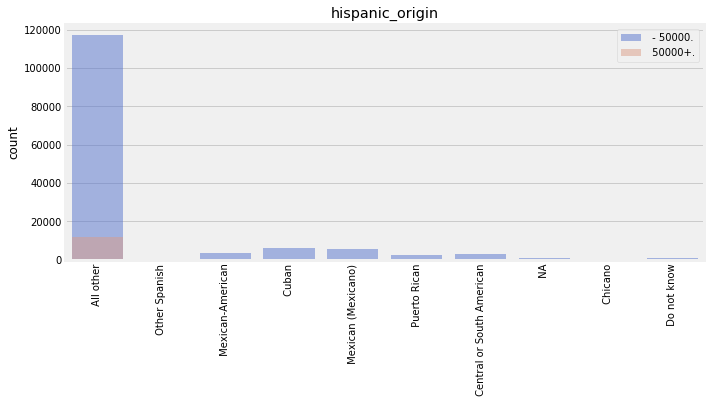

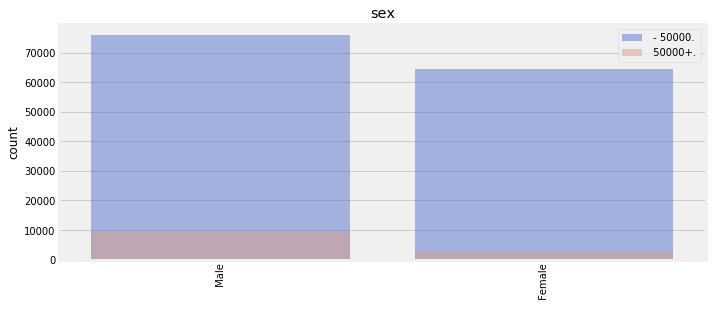

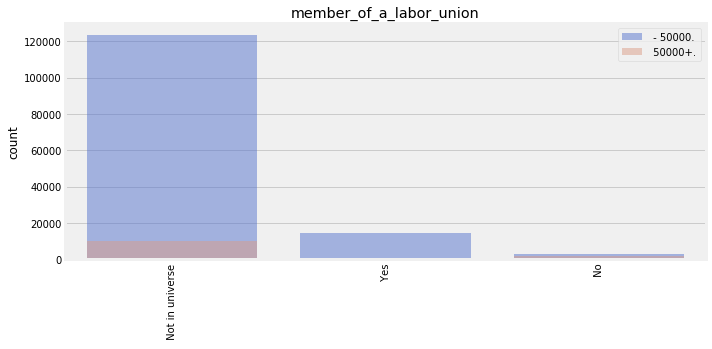

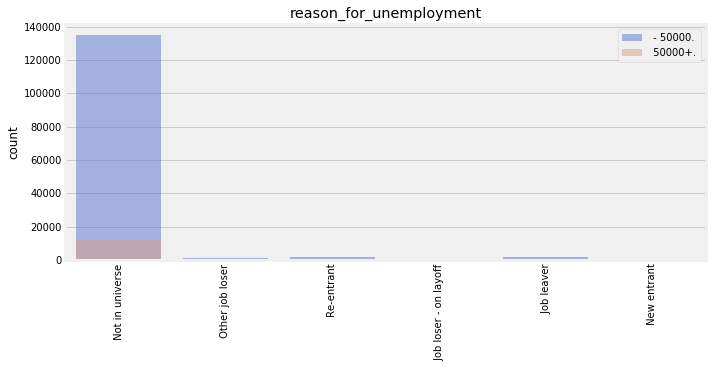

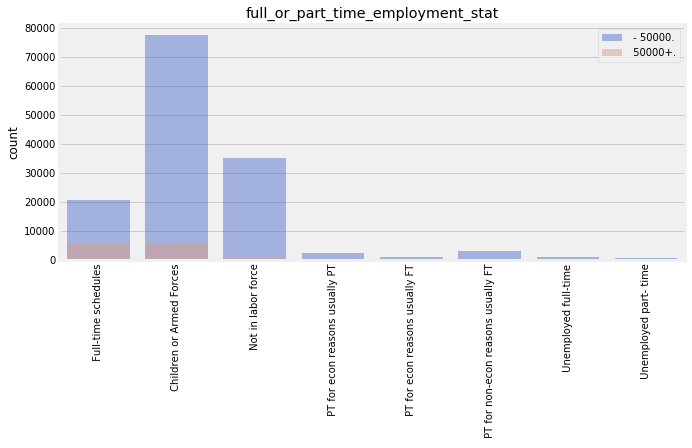

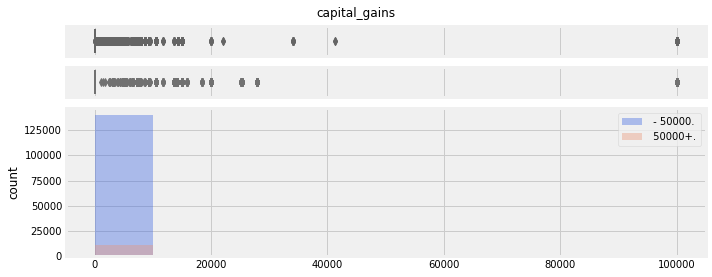

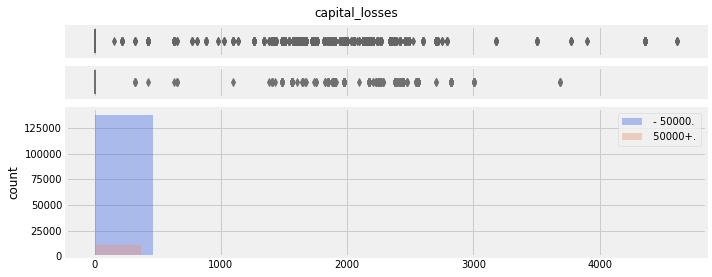

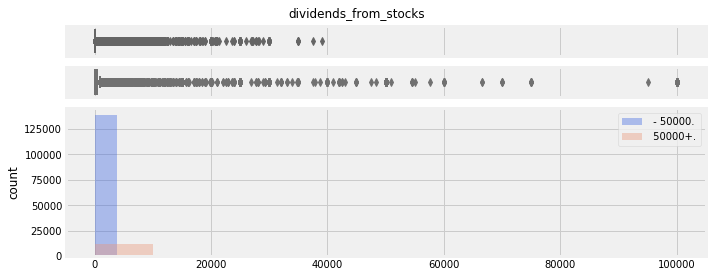

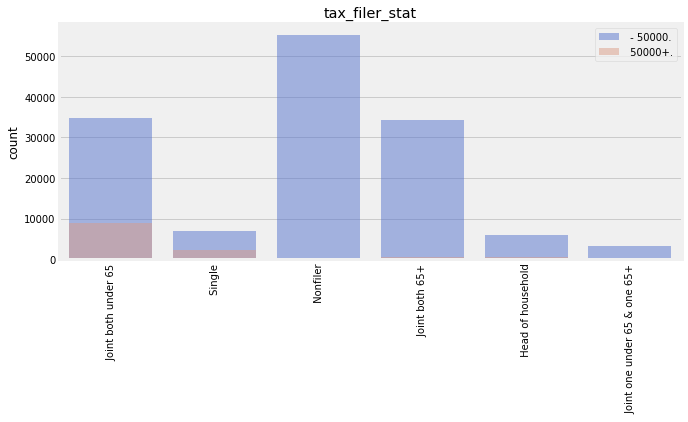

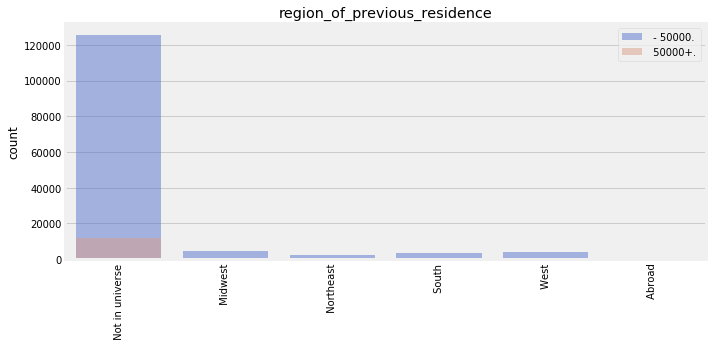

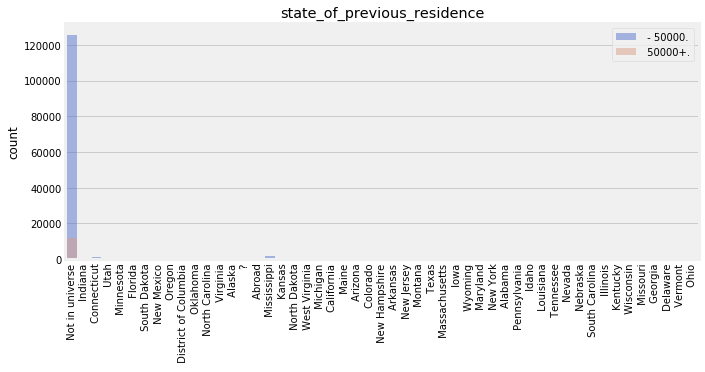

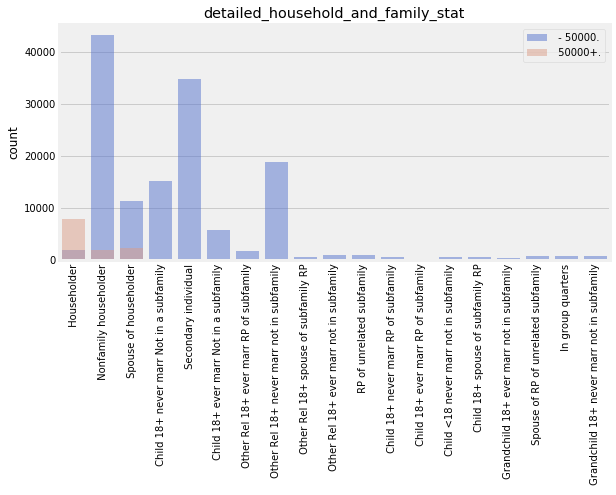

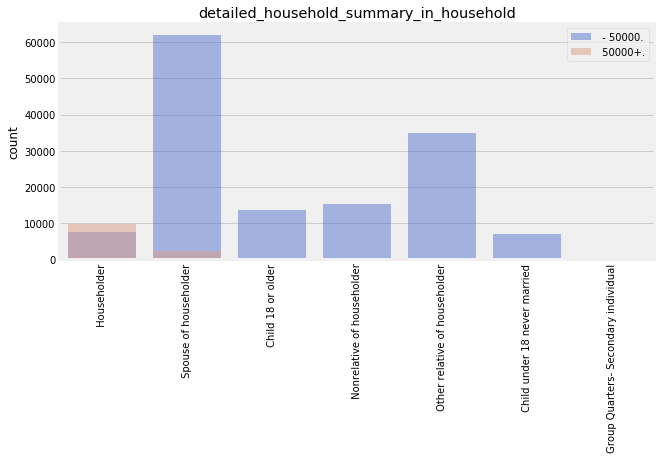

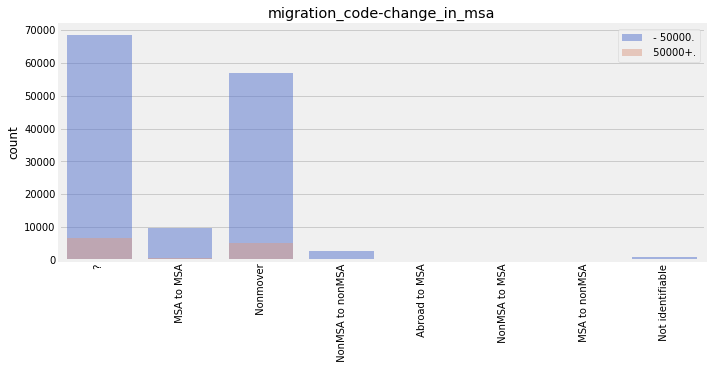

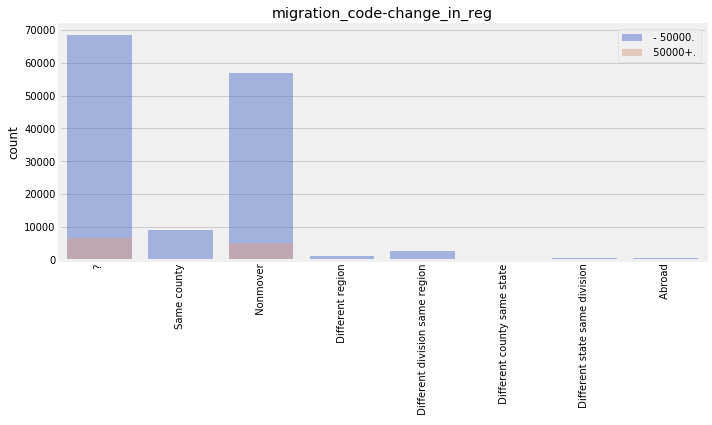

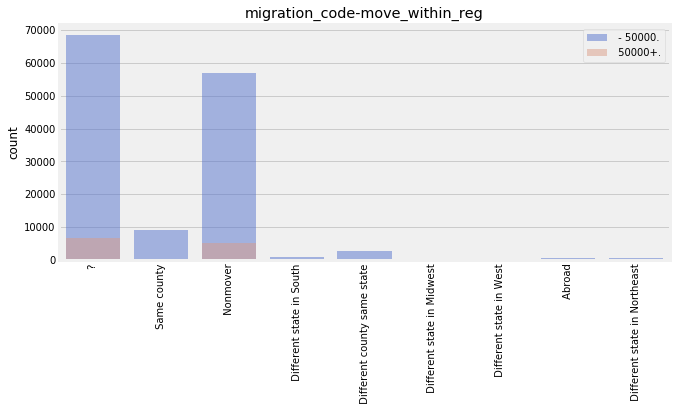

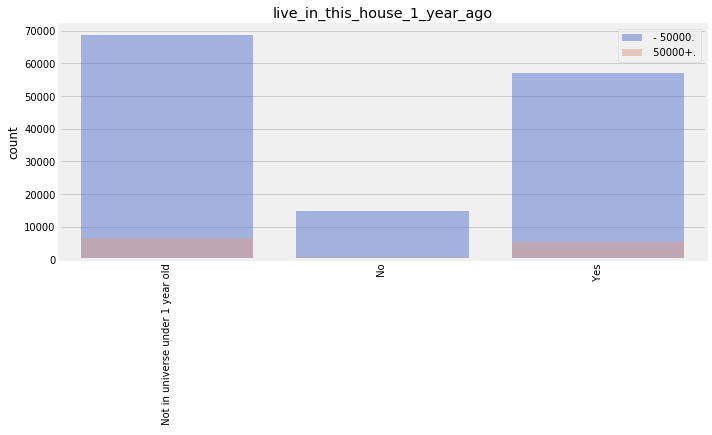

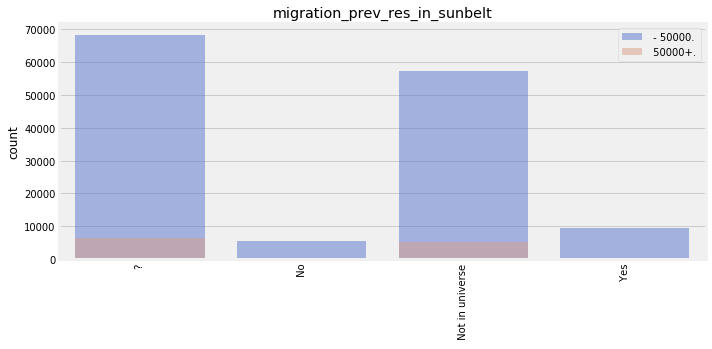

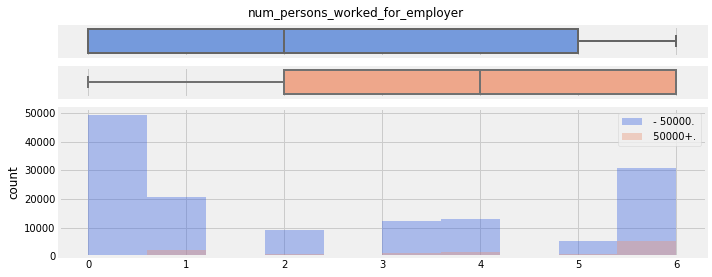

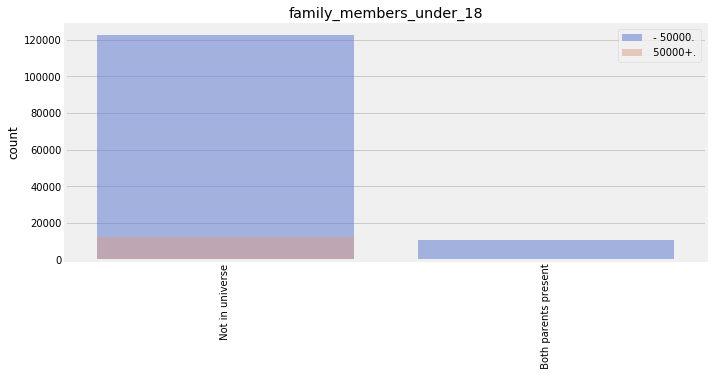

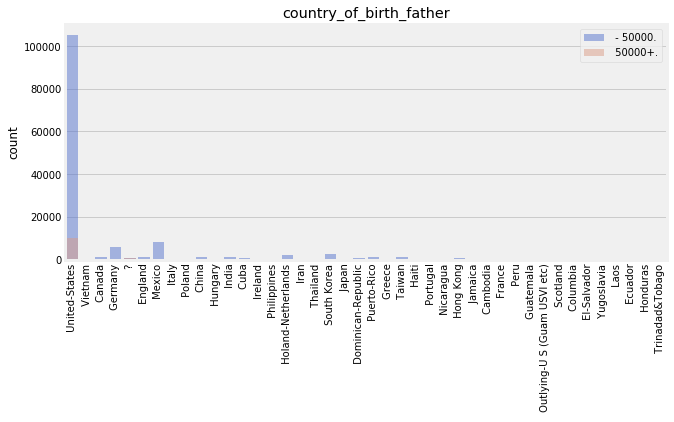

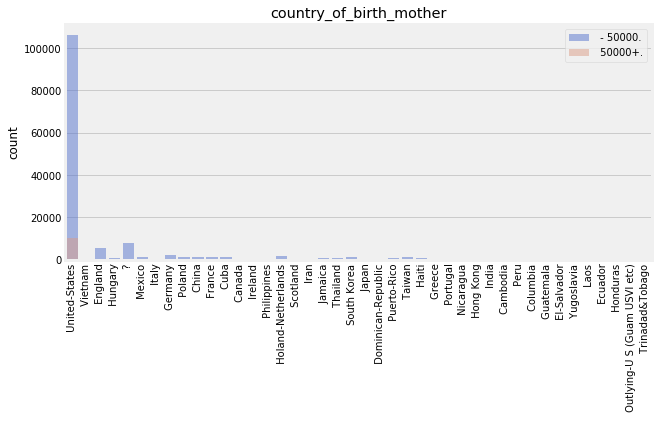

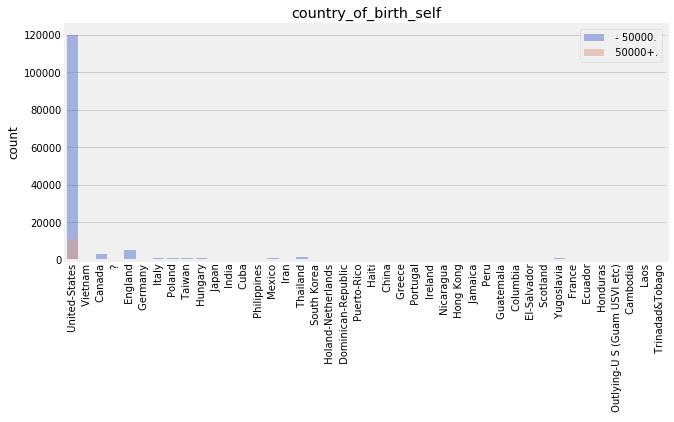

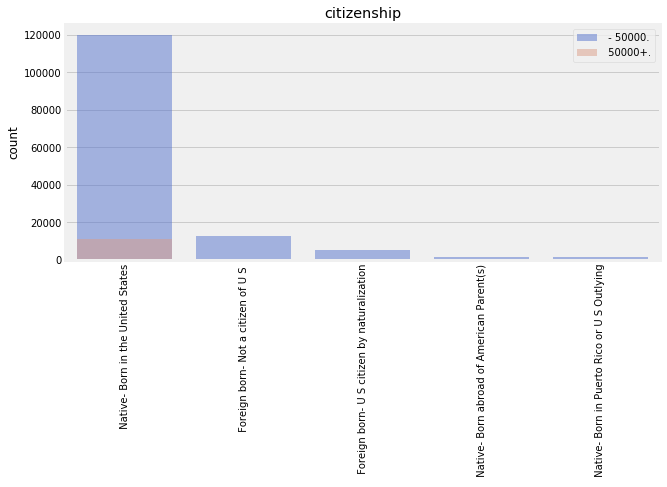

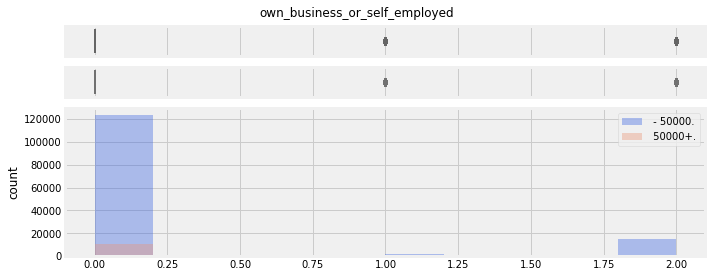

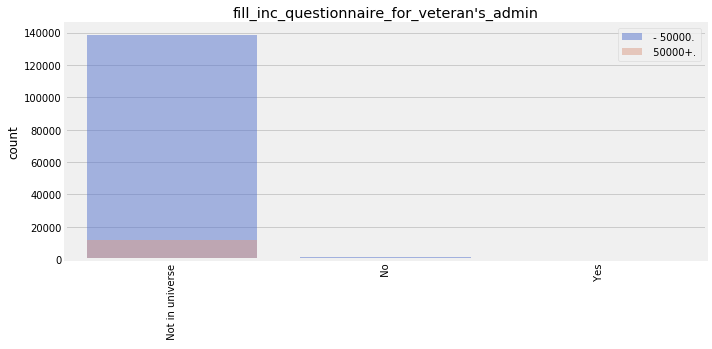

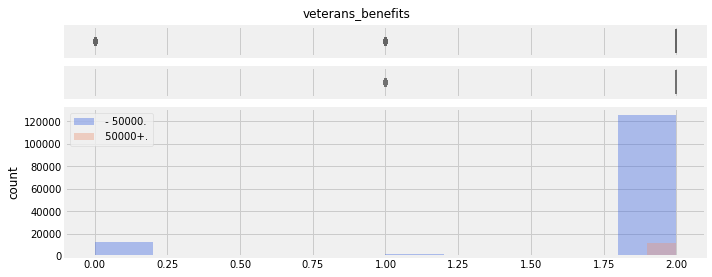

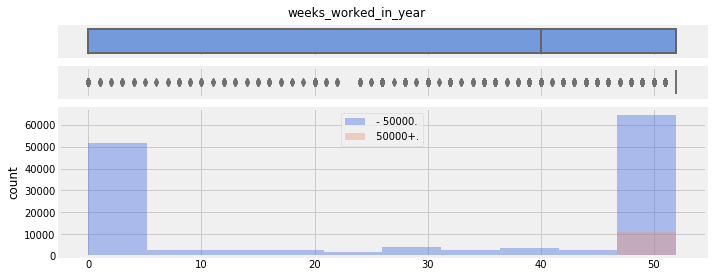

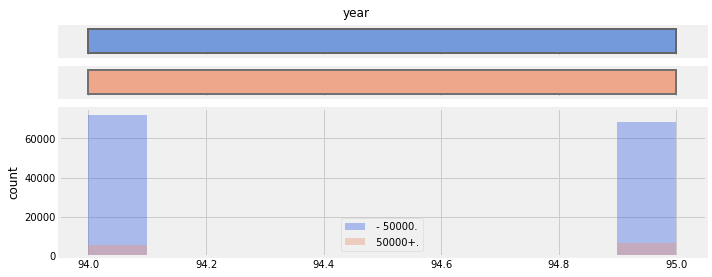

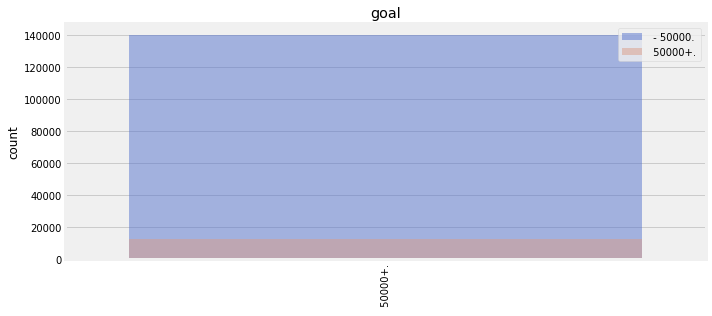

In [13]:
# Examine histograms for all columns and additionally box plots for only numerical columns
for column in train_data.columns:
    print('===================================================================================================')

    goal0 = train_data['goal'].unique()[0]
    goal1 = train_data['goal'].unique()[1]
    
    # If column is numerical, plot both boxplots and histograms
    if train_data[column].dtypes == 'int64':

        fig, (ax_box0, ax_box1, ax_hist) = plt.subplots(3, sharex=True, gridspec_kw= {"height_ratios": (0.2, 0.2, 1)}, figsize=(10, 4))
        sns.boxplot(train_data[train_data['goal'] == goal0][column], ax=ax_box0, color='cornflowerblue')
        ax_box0.set(xlabel='')

        sns.boxplot(train_data[train_data['goal'] == goal1][column], ax=ax_box1, color='lightsalmon')
        ax_box1.set(xlabel='')

        sns.distplot(train_data[train_data['goal'] == goal0][column],
                     bins=10,
                     color='royalblue',
                     ax=ax_hist,
                     label=goal0,
                     kde=False,
                     norm_hist=False)
        sns.distplot(train_data[train_data['goal'] == goal1][column],
                     bins=10,
                     color='darksalmon',
                     ax=ax_hist,
                     label=goal1,
                     kde=False,
                     norm_hist=False)
        ax_hist.set(xlabel='')
        ax_hist.set(ylabel='count')
        plt.legend()
        fig.suptitle(column)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    # If column is not numerical, only plot categorical histogram
    else:
        plt.figure(figsize=(10, 4))
        sns.countplot(train_data[train_data['goal'] == goal0][column],
                      color='royalblue',
                      label=goal0,
                      alpha=.5)
        sns.countplot(train_data[train_data['goal'] == goal1][column],
                      color='darksalmon',
                      label=goal1,
                      alpha=.5)
        plt.xlabel('')
        plt.legend()
        plt.title(column)
        plt.tight_layout()
        plt.xticks(rotation=90)
        plt.show()

I don't see any concerning outliers or irregularities.
The wages, capital gains and losses, and dividends columns have outliers, but with these types of columns that's to be expected.
Several histograms are heavily imbalanced but this shouldn't pose a problem particularly with the tree-based models.
There don't appear to be many differences between classes for most of the columns, this could cause model performance to suffer.
Columns which may be highly predictive are 'detailed_industry_recode', 'marital_stat', 'race', 'detailed_household_and_family_stat', 'num_persons_worked_for_employer', 'citizenship', and 'weeks_worked_in_year'.

## Prepare data for modeling

In [14]:
# Set aside a validation set in order to compare models
train_data, val_data = train_test_split(train_data, test_size=.1)

In [15]:
# Use one-hot encoding to handle categorical columns
train_df = pd.get_dummies(train_data, drop_first=True)
train_target = train_df['goal_ 50000+.']
train_df.drop('goal_ 50000+.', axis=1, inplace=True)

val_df = pd.get_dummies(val_data, drop_first=True)
val_target = val_df['goal_ 50000+.']
val_df.drop('goal_ 50000+.', axis=1, inplace=True)

test_df = pd.get_dummies(test_data, drop_first=True)
test_target = test_df['goal_ 50000+.']
test_df.drop('goal_ 50000+.', axis=1, inplace=True)

# Replace '<' in column names as required for xgboost
train_df.columns = train_df.columns.str.replace('<', 'greater_than_')
val_df.columns = val_df.columns.str.replace('<', 'greater_than_')
test_df.columns = test_df.columns.str.replace('<', 'greater_than_')

In [16]:
# Define function to ensure the test set has same one-hot encoded columns as train set
def dummy_columns(train_df, test_df):
    # Get missing columns in the training test
    missing_cols = set(train_df.columns) - set(test_df.columns)
    # Add any missing columns in test set with default value equal to 0
    for c in missing_cols:
        test_df[c] = 0
    # Ensure the order of columns in the test set is in the same order than in train set
    test_df = test_df[train_df.columns]
    return test_df

In [17]:
# Apply column matching function to test and validation sets
val_df = dummy_columns(train_df, val_df)
test_df = dummy_columns(train_df, test_df)

In [18]:
# Create normalized data for logistic regression and knn
train_df_norm = normalize(train_df)
val_df_norm = normalize(val_df)
test_df_norm = normalize(test_df)

In [19]:
# Assert data shapes all match as expected
print(train_df.shape)
print(train_df_norm.shape)
print(train_target.shape)
print(val_df.shape)
print(val_df_norm.shape)
print(val_target.shape)
print(test_df.shape)
print(test_df_norm.shape)
print(test_target.shape)

(137606, 380)
(137606, 380)
(137606,)
(15290, 380)
(15290, 380)
(15290,)
(78864, 380)
(78864, 380)
(78864,)


## Build and compare models

Build 3 model versions for each algorithm

1. All data unmodified
2. SMOTE class balancing
3. PCA dimensionality reduction

In [20]:
# Define functions for each algorithm to take data, perform grid search using 5-fold cross validation, and build a model
# Print best parameters and the performance metrics, and output the fitted model

def logistic_regression(train_df, train_target, test_df, test_target):
    parameters = {'penalty': ['l1', 'l2', 'none'],
                  'C':[.1, 1, 10],
                  'class_weight': ['balanced', None]}
    lr = LogisticRegression(solver='saga', n_jobs=-1)
    clf = GridSearchCV(lr, parameters, scoring='f1')
    clf.fit(train_df, train_target)
    print_results(clf, test_df, test_target)
    return clf

def knn(train_df, train_target, test_df, test_target):
    parameters = {'n_neighbors': [5, 10, 15]}
    knn = KNeighborsClassifier(n_jobs=-1)
    clf = GridSearchCV(knn, parameters, scoring='f1')
    clf.fit(train_df, train_target)
    print_results(clf, test_df, test_target)
    return clf

def random_forest(train_df, train_target, test_df, test_target):
    parameters = {'max_depth': [None, 5, 10],
                  'min_samples_split': [2, 3, 5],
                  'class_weight': ['balanced', None]}
    rf = RandomForestClassifier(n_jobs=-1)
    clf = GridSearchCV(rf, parameters, scoring='f1')
    clf.fit(train_df, train_target)
    print_results(clf, test_df, test_target)
    return clf

def xgboost(train_df, train_target, test_df, test_target):
    parameters = {'max_depth': [4, 6, 8],
                  'learning_rate': [.1, .3, .5]}
    xgb = XGBClassifier(verbosity=0, n_jobs=-1)
    clf = GridSearchCV(xgb, parameters, scoring='f1')
    clf.fit(train_df, train_target)
    print_results(clf, test_df, test_target)
    return clf

def print_results(clf, test_df, test_target):
    y_true = test_target
    y_pred = clf.predict(test_df)
    print('Best parameters: {}'.format(clf.best_params_))
    print('{:.1f}% - Accuracy'.format(100 * accuracy_score(y_true, y_pred)))
    print('{:.1f}% - F1 score'.format(100 * f1_score(y_true, y_pred)))
    print('{:.1f}% - Precision'.format(100 * precision_score(y_true, y_pred)))
    print('{:.1f}% - Recall'.format(100 * recall_score(y_true, y_pred)))

In [21]:
# Use normalized data for logistic regression and KNN, but not for random forest or XGBoost

## Base models

In [22]:
lr_base = logistic_regression(train_df_norm, train_target, val_df_norm, val_target)

Best parameters: {'C': 1, 'class_weight': 'balanced', 'penalty': 'l1'}
50.0% - Accuracy
23.3% - F1 score
13.3% - Precision
95.6% - Recall


In [23]:
knn_base = knn(train_df_norm, train_target, val_df_norm, val_target)

Best parameters: {'n_neighbors': 5}
92.9% - Accuracy
47.7% - F1 score
57.7% - Precision
40.7% - Recall


In [24]:
rf_base = random_forest(train_df, train_target, val_df, val_target)

Best parameters: {'learning_rate': 0.5, 'max_depth': 6}
93.3% - Accuracy
56.4% - F1 score
58.9% - Precision
54.1% - Recall


In [25]:
xgb_base = xgboost(train_df, train_target, val_df, val_target)

Best parameters: {'learning_rate': 0.5, 'max_depth': 6}
94.5% - Accuracy
58.7% - F1 score
72.3% - Precision
49.3% - Recall


## SMOTE for class balancing

In [26]:
sm = SMOTE()
train_df_resample, train_target_resample = sm.fit_resample(train_df, train_target)
train_df_resample_norm = normalize(train_df_resample)

In [27]:
print(train_df_resample.shape)
print(train_df_resample_norm.shape)
print(train_target_resample.shape)

(252864, 380)
(252864, 380)
(252864,)


In [28]:
lr_smote = logistic_regression(train_df_resample_norm, train_target_resample, val_df, val_target)

Best parameters: {'C': 10, 'class_weight': 'balanced', 'penalty': 'none'}
92.1% - Accuracy
2.9% - F1 score
56.2% - Precision
1.5% - Recall


In [29]:
knn_smote = knn(train_df_resample_norm, train_target_resample, val_df, val_target)

Best parameters: {'n_neighbors': 5}
83.9% - Accuracy
42.2% - F1 score
29.5% - Precision
73.8% - Recall


In [30]:
rf_smote = random_forest(train_df_resample, train_target_resample, val_df, val_target)

Best parameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 3}
93.3% - Accuracy
52.6% - F1 score
60.2% - Precision
46.7% - Recall


In [31]:
xgb_smote = xgboost(train_df_resample, train_target_resample, val_df, val_target)

Best parameters: {'learning_rate': 0.3, 'max_depth': 8}
93.8% - Accuracy
58.7% - F1 score
62.1% - Precision
55.7% - Recall


## PCA for dimensionality reduction

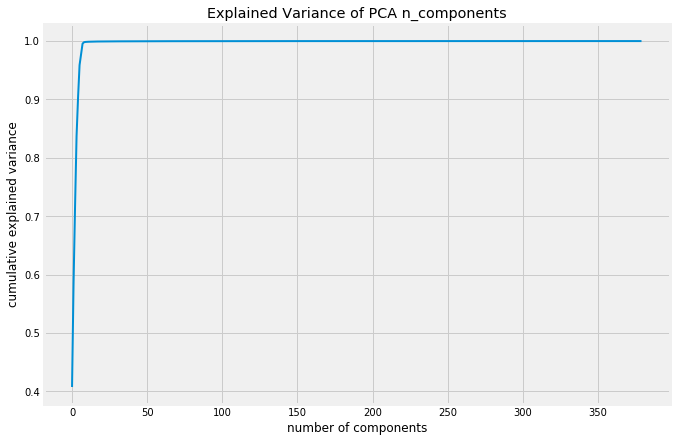

In [32]:
# First, let's check how many components to keep
pca = PCA().fit(train_df_norm)
plt.figure(figsize=(10, 7))
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('Explained Variance of PCA n_components')
plt.show()

In [33]:
for i, component in enumerate(pca.explained_variance_ratio_.cumsum().tolist()[:10]):
    print('The first {} components explain {:.1f}% of the variance'.format(i + 1, 100 * component))

The first 1 components explain 40.8% of the variance
The first 2 components explain 58.5% of the variance
The first 3 components explain 71.7% of the variance
The first 4 components explain 83.7% of the variance
The first 5 components explain 90.3% of the variance
The first 6 components explain 95.9% of the variance
The first 7 components explain 97.8% of the variance
The first 8 components explain 99.6% of the variance
The first 9 components explain 99.8% of the variance
The first 10 components explain 99.9% of the variance


In [34]:
# Keep 10 components to capture 99.9% of data variance
pca = PCA(n_components=10)
train_df_pca = pca.fit_transform(train_df_norm)
val_df_pca = pca.transform(val_df_norm)
test_df_pca = pca.transform(test_df_norm)

In [35]:
print(train_df_pca.shape)
print(val_df_pca.shape)
print(test_df_pca.shape)

(137606, 10)
(15290, 10)
(78864, 10)


In [36]:
lr_pca = logistic_regression(train_df_pca, train_target, val_df_pca, val_target)

Best parameters: {'C': 1, 'class_weight': 'balanced', 'penalty': 'l2'}
75.1% - Accuracy
34.5% - F1 score
21.8% - Precision
82.3% - Recall


In [37]:
knn_pca = knn(train_df_pca, train_target, val_df_pca, val_target)

Best parameters: {'n_neighbors': 5}
92.8% - Accuracy
46.9% - F1 score
57.4% - Precision
39.7% - Recall


In [38]:
rf_pca = random_forest(train_df_pca, train_target, val_df_pca, val_target)

Best parameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 5}
93.1% - Accuracy
49.9% - F1 score
59.4% - Precision
42.9% - Recall


In [39]:
xgb_pca = xgboost(train_df_pca, train_target, val_df_pca, val_target)

Best parameters: {'learning_rate': 0.5, 'max_depth': 8}
93.3% - Accuracy
47.0% - F1 score
63.2% - Precision
37.4% - Recall


I was surprised at how poorly the base logistic regression model performed (indicative of non-linear relationships), and how well the KNN model performed given the high dimensionality. I was also expecting the SMOTE technique for class balancing to increase performance more significantly, although because I was optimizing my models for f1 score instead of accuracy, this may explain it. Also, I was surprised that only 10 features could account for 99.9% of the variance of the data; this means that many of the columns are essentially meaningless. Using PCA, as expected, increased performance of the logistic regression and KNN models, as simplier models would be expected to perform better in cross validation, and barely affected the non-linear tree models, again as would be expected. PCA did, however, vastly increase the speed of fitting the models. These models handle many features very well. In the end, the two tree-based models performed best, with XGBoost slightly edging out the random forest. Boosted trees have a tendency to overfit, but by cross-validating and then testing on a holdout validation set, I am confident that overfitting is under control.

## Examine most important features

In [40]:
# Recombine train and validation sets to train final model
rf_final = RandomForestClassifier(n_jobs=-1,
                                  max_depth=None,
                                  min_samples_split=5).fit(pd.concat([train_df, val_df]),
                                                           pd.concat([train_target, val_target]))

In [41]:
importances = rf_final.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_final.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

In [42]:
# Print the feature ranking
print("Feature ranking:")

for f in range(train_df.shape[1]):
    print('{}. {:.2f}% - {}'.format(f + 1, 100 * importances[indices[f]], train_df.columns[indices[f]]))

Feature ranking:
1. 8.49% - dividends_from_stocks
2. 8.01% - capital_gains
3. 7.81% - age
4. 6.94% - detailed_occupation_recode
5. 3.83% - detailed_industry_recode
6. 3.63% - num_persons_worked_for_employer
7. 3.18% - weeks_worked_in_year
8. 2.93% - sex_ Male
9. 2.60% - capital_losses
10. 2.36% - major_occupation_code_ Executive admin and managerial
11. 1.93% - education_ Masters degree(MA MS MEng MEd MSW MBA)
12. 1.88% - major_occupation_code_ Professional specialty
13. 1.79% - education_ Prof school degree (MD DDS DVM LLB JD)
14. 1.62% - education_ Bachelors degree(BA AB BS)
15. 1.27% - detailed_household_and_family_stat_ Householder
16. 1.23% - own_business_or_self_employed
17. 1.17% - detailed_household_summary_in_household_ Householder
18. 1.15% - education_ High school graduate
19. 1.13% - education_ Doctorate degree(PhD EdD)
20. 1.08% - wage_per_hour
21. 0.97% - tax_filer_stat_ Joint both under 65
22. 0.91% - class_of_worker_ Self-employed-incorporated
23. 0.88% - member_of_a_la

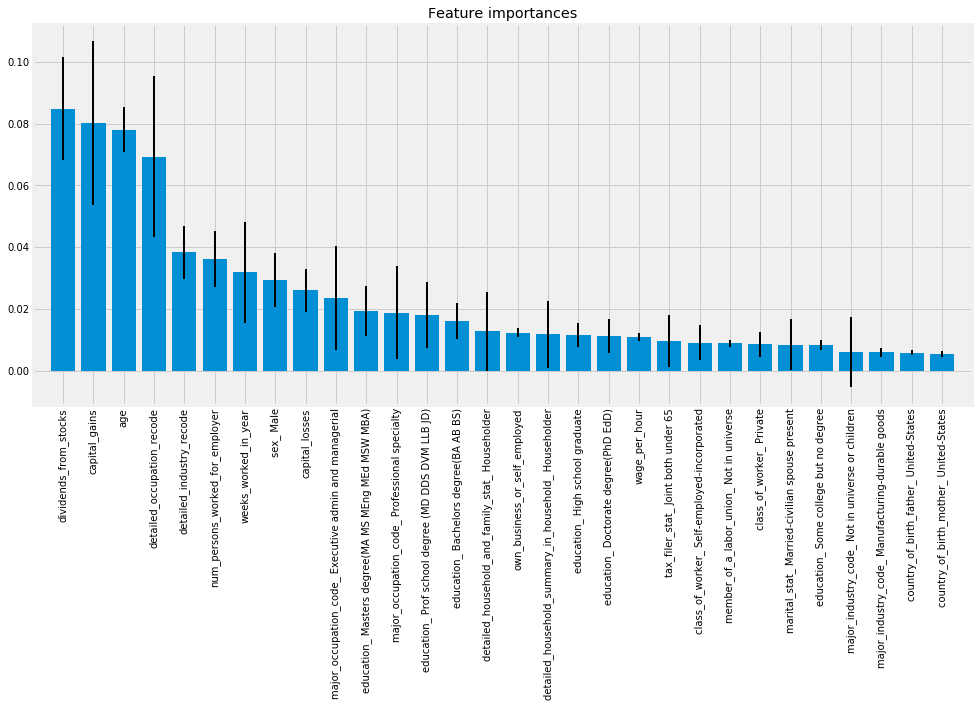

In [43]:
# Plot the feature importances of the random forest model
n = 30

plt.figure(figsize=(15, 7))
plt.title("Feature importances")
plt.bar(range(train_df.shape[1])[:n], importances[indices[:n]], yerr=std[indices[:n]], align="center")
plt.xticks(range(train_df.shape[1])[:n], train_df.columns[indices[:n]], rotation=90)
plt.xlim([-1, n])
plt.show()

In [44]:
xgb_final = XGBClassifier(learning_rate=0.5,
                          max_depth=6,
                          verbosity=0,
                          n_jobs=-1).fit(pd.concat([train_df, val_df]),
                                         pd.concat([train_target, val_target]))

In [45]:
importances = xgb_final.get_booster().get_score(importance_type="gain")
indices = sorted(importances, key=importances.get)[::-1]

In [46]:
# Print the feature ranking
print("Feature ranking:")

for f, idx in enumerate(indices):
    print('{}. {:.2f} - {}'.format(f + 1, importances[idx], idx))

Feature ranking:
1. 71.51 - tax_filer_stat_ Nonfiler
2. 61.69 - capital_gains
3. 54.57 - sex_ Male
4. 53.86 - weeks_worked_in_year
5. 38.25 - major_occupation_code_ Other service
6. 37.18 - education_ Prof school degree (MD DDS DVM LLB JD)
7. 29.43 - major_occupation_code_ Protective services
8. 28.04 - hispanic_origin_ Mexican (Mexicano)
9. 26.41 - education_ Doctorate degree(PhD EdD)
10. 25.01 - detailed_occupation_recode
11. 21.96 - education_ Masters degree(MA MS MEng MEd MSW MBA)
12. 21.31 - education_ High school graduate
13. 20.18 - dividends_from_stocks
14. 19.04 - major_industry_code_ Education
15. 18.52 - capital_losses
16. 18.05 - detailed_household_and_family_stat_ Child 18+ never marr Not in a subfamily
17. 16.51 - class_of_worker_ Self-employed-incorporated
18. 16.09 - education_ 11th grade
19. 14.72 - major_industry_code_ Retail trade
20. 14.42 - tax_filer_stat_ Joint both under 65
21. 13.41 - class_of_worker_ Not in universe
22. 12.30 - education_ 5th or 6th grade
23. 1

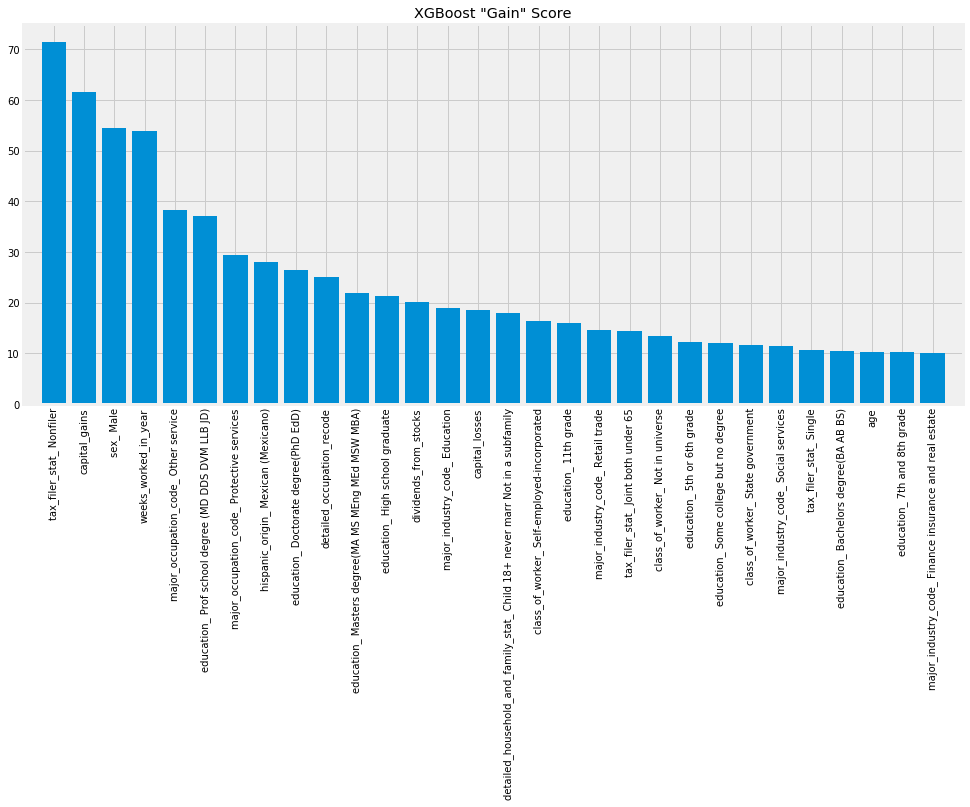

In [47]:
# Plot the feature importances of the XGBoost model
n = 30

plt.figure(figsize=(15, 7))
plt.title('XGBoost "Gain" Score')
plt.bar(range(len(importances))[:n], [importances[idx] for idx in indices[:n]], align="center")
plt.xticks(range(len(importances))[:n], indices[:n], rotation=90)
plt.xlim([-1, n])
plt.show()

As suggested by the PCA analysis, only a few features make up most of the predictive capabilities of the models. The features which I guessed would be informative, based upon their histograms, did indeed feature high on the list of importances. The most informative features (as determined by the random forest) turned out to be:

1. dividends_from_stocks
2. capital_gains
3. age
4. detailed_occupation_recode
5. detailed_industry_recode
6. num_persons_worked_for_employer
7. weeks_worked_in_year
8. sex (male)
9. capital_losses
10. major_occupation_code_ (Executive admin and managerial)

Intuitively, these features make sense. There are several financial features indicative of high-earners (stock dividends, capital gains and losses) as well as some demographic features which are also known to be correlated with high earners (male managers). The 11th feature was for a masters degree, another strong indicator. Obviously, more weeks worked in a year is going to lead to more earnings. Both age and occupation/industry are also strongly linked to income.

## Apply the best model to the test set and calculate final performance metrics for reporting

In [48]:
y_true = test_target
y_pred = xgb_final.predict(test_df)

print('Performance metrics for final XGBoost model:')
print('{:.1f}% - Accuracy'.format(100 * accuracy_score(y_true, y_pred)))
print('{:.1f}% - F1 score'.format(100 * f1_score(y_true, y_pred)))
print('{:.1f}% - Precision'.format(100 * precision_score(y_true, y_pred)))
print('{:.1f}% - Recall'.format(100 * recall_score(y_true, y_pred)))

Performance metrics for final XGBoost model:
94.7% - Accuracy
59.5% - F1 score
74.4% - Precision
49.6% - Recall


The XGBoost model showed better performance on the holdout test set than on the validation set. This is most likely due to random chance in the train/test split. It does offer great confidence, however, that the model is neither overfit nor underfit. Given the high class imbalance, accuracy would be expected to be high but the f1 score is the real indicator of performance, and it is a great improvement over a random-guess model.

## Further steps
1. try a few other algorithms, eg Naive Bayes, SVC, neural network
2. create a majority voting ensemble classifier with all models
3. more rigorously grid search (some hyperparameters were ignored to save computing time)
4. try under-sampling instead of over-sampling
5. combine PCA and SMOTE